<div class="head0">
    <div class="head0__name">
        Diffusion equation with linear drift in 1D case
    </div>
    <div class="head0__note">
        Solution of the 1D Fokker-Planck equation by fast and accurate tensor based method with linear drift (Ornstein–Uhlenbeck process).
    </div>
</div>

In [1]:
import sys
import time

import numpy as np
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt

sys.path.extend(['./../lib', './../helpers'])
from intertrain import Intertrain
from solver import Solver as Solver

from helpers import init_jupyter; init_jupyter()

Start |  5:27PM MSK on Sep 03, 2019 |
-------------------------------------


<div class="head1">
    <div class="head1__name">
        Multivariate Ornstein–Uhlenbeck process
    </div>
</div>

Consider SDE
$$
    dx = f(x, t) \, dt + S(x, t) \, d\beta,
    \quad
    d\beta \, d\beta^{\top} = Q(t) dt,
    \quad
    x(0) = x_0 \sim \rho(x, 0) = \rho_0 (x),
$$
where spatial $d$-dimensional ($d \ge 1$) variable $x \in R^d$ has probability density function (PDF) $\rho(x, t)$, $\beta$ is Brownian motion of dimension $q$ ($q \ge 1$, and we assume below that $q = d$), $f(x, t) \in R^d$ is a vector-function and $S(x, t) \in R^{d \times q}$ is a matrix-function.

It can be shown that the PDF $\rho(x, t)$ at time $t$ ($t > 0$) is the solution of the Fokker-Planck equation
$$
    \frac{\partial \rho(x, t)}{\partial t} =
        - \sum_{i=1}^d
            \frac{\partial}{\partial x_i}
            \left[ f_i(x, t) \rho(x, t) \right]
        + \sum_{i=1}^d \sum_{j=1}^d
            \frac{\partial^2}{\partial x_i \partial x_j}
            \left[ D_{ij}(x, t) \rho(x, t) \right],
    \quad
    \rho(x, 0) = \rho_0(x),
$$
where $D(x, t)$ is a diffusion tensor of the form
$$
    D(x, t) = \frac{1}{2} S(x, t) Q S^{\top}(x, t).
$$

Let
$$
    f(x, t) \equiv A \left( \mu - x(t) \right),
    \quad
    S(x, t) \equiv S,
    \quad
    D(x, t) \equiv I,
$$
then we come to the multivariate Ornstein–Uhlenbeck process
$$
    d \, x(t) = A \left( \mu - x(t) \right) d \, t + S d \, \beta(t),
$$
$$
    \frac{\partial \rho}{\partial t} =
        \Delta \rho - A div \left[ \left( \mu - x(t) \right) \rho \right],
    \quad
    \rho(x, 0) = \rho_0(x),
$$

where

- $x \in R^d$ is a stochastic process;

- $\beta \in R^q$ is a Brownian motion;

- $\mu \in R^{d}$ is the long-term mean;

- $A \in R^{d \times d}$ is the velocity (invertible real matrix);

- $S \in R^{d \times q}$ are the friction coefficients (positive real matrix).

It can be shown (see [Alternative way to derive the distribution of the multivariate Ornstein–Uhlenbeck process](https://advancesindifferenceequations.springeropen.com/articles/10.1186/s13662-019-2214-1)) that

- Mean vector
$
    M(t, x_0) = e^{-A t} x_0 + \left( I - e^{-A t} \right) \mu
$;

- Covariance matrix
$
    \Sigma(t) = \int_0^t e^{A (s-t)} S S^T e^{A^T (s-t)} d \, s
$;

- Transitional PDF
$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{ | 2 \pi \Sigma(t) | }}
        exp \left[
            -\frac{1}{2} (x - M(t, x_0))^T \Sigma^{-1}(t) (x - M(t, x_0))
        \right]
$.

- The (multivariate) Ornstein–Uhlenbeck process, at any time, is a (multivariate) normal random variable.

- The Ornstein–Uhlenbeck process is mean-reverting (the solution tends to its long-term mean $\mu$ as time $t$ tends to infinity) if all eigenvalues of $A$ are positive (if $A > 0$ in the one dimensional case).

<div class="head1">
    <div class="head1__name">
        Model problem
    </div>
</div>

Let solve
$$
    dx = f(x, t) \, dt + S \, d\beta,
    \quad
    \frac{\partial \rho}{\partial t} = D \Delta \rho - div \left[ f(x, t) \rho \right],
    \quad
    \rho(x, 0) = \rho_0(x),
$$
with
$$
    f(x, t) \equiv A \left( \mu - x(t) \right),
$$
where $A > 0$ is the velocity, $\mu$ is the long-term mean, $S > 0$ is the friction coefficient and $D$ is the diffusion coefficient.

Let $\mu \equiv 0$, $S \equiv 1$ and $D \equiv \frac{1}{2}$, then we have according to properties of the multivariate Ornstein–Uhlenbeck process

- Mean value
$
    M(t, x_0) = e^{-A t} x_0
$;

- Covariance matrix
$
    \Sigma(t) = \frac{1 - e^{-2 A t}}{2 A} 
$;

- Transition PDF
$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{2 \pi \Sigma(t)}}
        exp \left[
            -\frac{(x - M(t, x_0))^2}{2 \Sigma(t)}
        \right] =  
            \sqrt{
                \frac{A}{\pi \left( 1 - e^{-2 A t} \right)}
            }
            e^{\frac
                {-A \left( x - x_0 e^{-A t} \right)^2}
                {1 - e^{-2 A t}}
            }
$.

- Stationary PDF ($t \rightarrow \infty$)
$
    \rho_{\infty}(x) =  
        \sqrt{
            \frac{A}{\pi}
        }
        e^{-A x^2}
$.

- PDF
$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)}
            }
        \exp{\left[
            - \frac
                {
                    x^2
                }
                {
                    2 \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        \right]}
$  for initial condition
$
    \rho_0(x) =
        \frac{1}{\sqrt{2 \pi s}}
        \exp{\left[
            -\frac{x^2}{2 s}
        \right]}
$.

> See proof for the formula of PDF at the end of this file.

In [2]:
A = 1.
s = 1.
dc = 0.5

def func_f0(x, t):
    m = 0.
    return A * (m - x)

def func_f1(x, t):
    return -A * np.ones(x.shape)

def func_xm(t, x0):
    return np.exp(-A * t) * x0
 
def func_xc(t):
    return (1. - np.exp(-2. * A * t)) / 2. / A

def func_r0(x):
    m = 0.
    r = np.exp(-0.5 * (x - m)**2 / s) / np.sqrt(2. * np.pi * s)
    return r.reshape(-1)

def func_rx(x, t, x0):
    m = func_xm(t, x0)
    c = func_xc(t)
    r = np.exp(-0.5 * (x - m)**2 / c) / np.sqrt(2. * np.pi * c)
    return r.reshape(-1)

def func_rt(x, t):
    S = func_xc(t) + s * np.exp(-2. * A * t)
    r = np.exp(-0.5 * x**2 / S) / np.sqrt(2. * np.pi * S)
    return r.reshape(-1)

def func_rs(x):
    r = np.sqrt(A / np.pi) * np.exp(- A * x * x)
    return r.reshape(-1)

def show_x(X, r_calc, _time):
    X = X.reshape(1, -1)
    r_init = func_r0(X.reshape(1, -1))
    r_real = func_rt(X.reshape(1, -1), t_max)
    r_stat = func_rs(X.reshape(1, -1))
    e = np.linalg.norm(r_real - r_calc) / np.linalg.norm(r_real)

    plt.plot(
        X.reshape(-1), r_init, '--', label='Initial',
        linewidth=3, color='tab:blue'
    )
    plt.plot(
        X.reshape(-1), r_calc, label='Calculated',
        linewidth=1, color='tab:green', marker='o', markersize=7,
        markerfacecolor='lightgreen', markeredgecolor='g'
    )
    plt.plot(
        X.reshape(-1), r_real, label='Analytic',
        linewidth=3, color='black'
    )
    plt.plot(
        X.reshape(-1), r_stat, '--', label='Stationary',
        linewidth=2, color='magenta'
    )
    
    plt.title('Solution at final time step')
    plt.xlabel('x')
    plt.ylabel('r')
    plt.legend(loc='best')
    plt.show()

    print('Number of spatial points : %8d'%x_poi)
    print('Number of time points    : %8d'%t_poi)
    print('Error (relative norm)    : %-12.2e'%e)
    print('Total time (sec)         : %-12.2e'%_time)

In [3]:
t_poi = 1000
t_min = 0.
t_max = 3.0

x_poi = 100
x_min = -5.
x_max = +5.

m = t_poi
n = x_poi
l = (x_max - x_min) / x_poi
h = (t_max - t_min) / (t_poi - 1)
T = np.linspace(t_min, t_max, t_poi)

print('Time-space factor (h/l^2) : %-8.5f'%(h/l/l))

Time-space factor (h/l^2) : 0.30030 


<div class="head1">
    <div class="head1__name">
        Explicit solution
    </div>
    <div class="head1__note">
        Euler solver and uniform spatial grid (only for example)
    </div>
</div>

We can solve this 1D equation on the uniform spatial grid for the time $t > 0$ with step $h$ and uniform spatial grid with step $l$ using 2th order finite difference scheme

$$
    \frac{\partial \rho}{\partial t} = (D + \widehat{Q}) \rho,
$$
where
$$
    \widehat{Q} \rho = f Q \rho - \frac{\partial f}{\partial x} \rho,
$$

$$
    D = \frac{1}{l^2} tridiag \left( 1, -2, 1 \right),
    \quad
    Q = \frac{1}{2 l} tridiag \left( -1, 0, 1 \right).
$$

Let apply 1th order splitting method on the time step $(k+1)$
$$
    \frac{\partial v}{\partial t} = D v,
    \quad
    v_{k} = \rho_{k},
    \quad
    v_{k+1} = v = ?,
$$
$$
    \frac{\partial w}{\partial t} = \widehat{Q} w,
    \quad
    w_{k} = v,
    \quad
    w_{k+1} = \rho_{k+1} = ?,
$$
and solve both ODE by the 1th order Euler method.

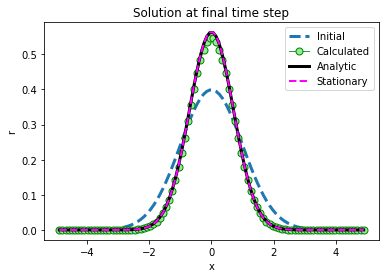

Number of spatial points :      100
Number of time points    :     1000
Error (relative norm)    : 2.92e-02    
Total time (sec)         : 2.60e-01    


In [4]:
_time = time.time()

X = np.linspace(x_min, x_max, x_poi).reshape(1, -1)[:, 1:-1]
Q = sp.spdiags([ [-1.]*n, [1.]*n ], [-1,  1], n, n).tocsr() 
Q = (Q / 2 / l).toarray()[1:-1, 1:-1]
D = sp.spdiags([ [1.]*n, [-2.]*n, [1.]*n ], [-1, 0, 1], n, n).tocsr() 
D = (D / l / l).toarray()[1:-1, 1:-1]
D = dc * D

# ZD = expm(h * D)

r = func_r0(X.reshape(1, -1)).reshape(-1, 1)
for t in T[1:]:
    F0 = np.diag(func_f0(X, t).reshape(-1))
    F1 = np.diag(func_f1(X, t).reshape(-1))
    w0 = r
    w1 = w0 + h * D @ w0
    # w1 = ZD @ w0
    v0 = w1
    v1 = v0 - h * F0 @ Q @ v0 - h * F1 @ v0
    r = v1
    
show_x(X, r.reshape(-1), time.time() - _time)

<div class="head1">
    <div class="head1__name">
        Solution by the solver
    </div>
</div>

In [6]:
SL = Solver(d=1, with_tt=False)
SL.set_grid_t(t_poi, t_min, t_max, t_poi_hst=10)
SL.set_grid_x(x_poi, x_min, x_max)
SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
SL.set_coefs(dc)
SL.prep()
SL.calc()

Solve: 100%|█| 999/999 [00:06<00:00, 159.54step/s, | At T = 3.00e+00 : err=1.95e-03]


<div class="head2">
    <div class="head2__name">
        Solution near boundaries
    </div>
    <div class="head2__note">
        Analytic solution is not vanish on the boundaries at selected time interval (but stationary solution will be zero), so we could not expect very good accuracy of our solver.
    </div>
</div>

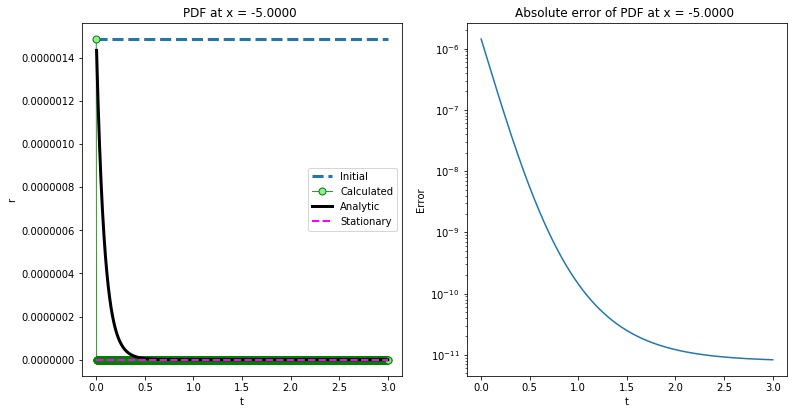

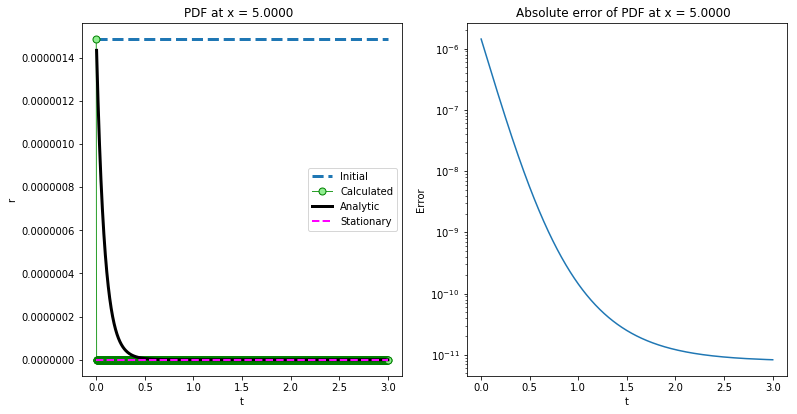

In [7]:
SL.plot_t(x=x_min, is_err_abs=True)
SL.plot_t(x=x_max, is_err_abs=True)

<div class="head2">
    <div class="head2__name">
        Solution in the inner points
    </div>
    <div class="head2__note">
        Solution is rather accurate.
    </div>
</div>

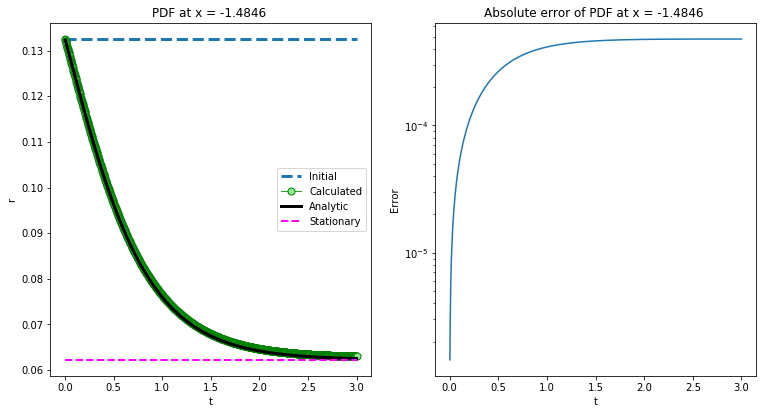

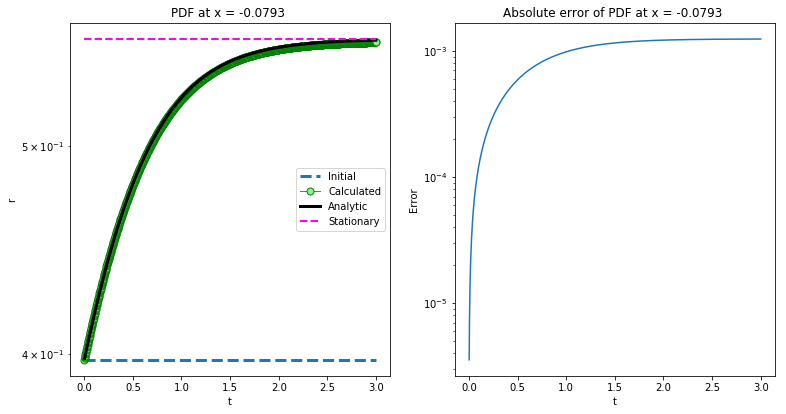

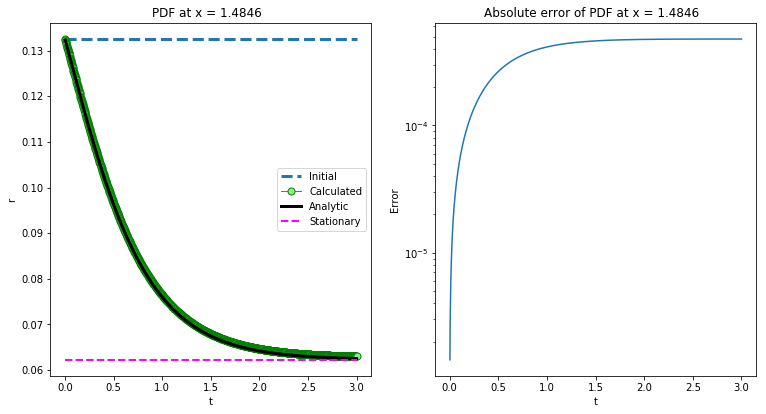

In [8]:
SL.plot_t(x=-1.5, is_err_abs=True)
SL.plot_t(x=+0.0, is_log=True, is_err_abs=True)
SL.plot_t(x=+1.5, is_err_abs=True)

<div class="head2">
    <div class="head2__name">
        Solution for different time steps
    </div>
    <div class="head2__note">
        Solution is not accurate at the final time step since analytic solution is not vanish on the boundaries.
    </div>
</div>

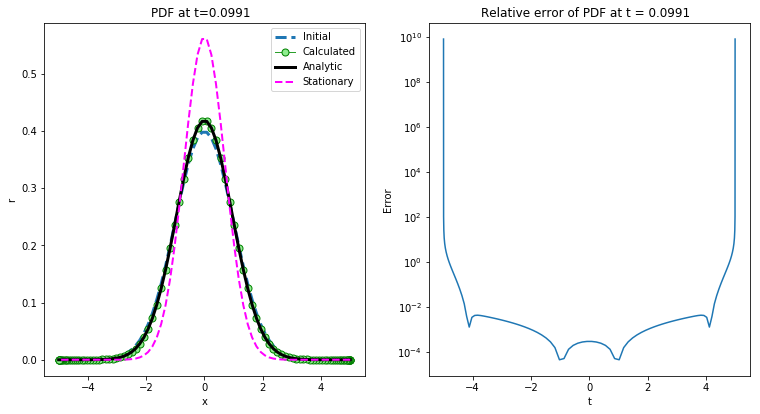

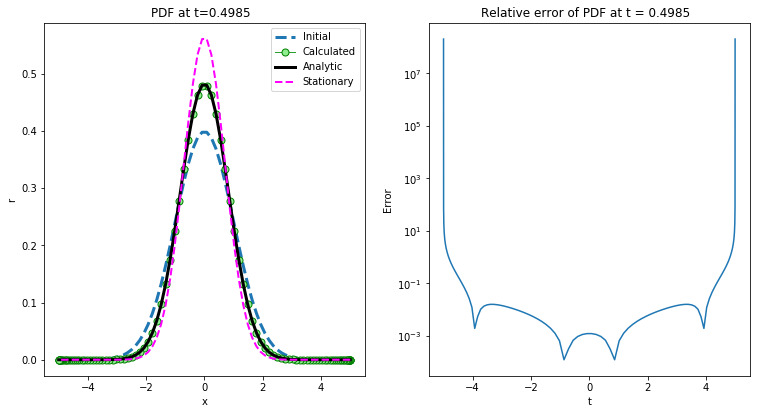

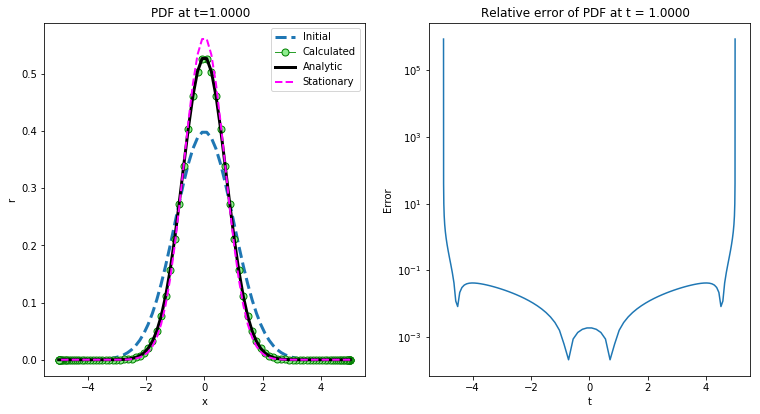

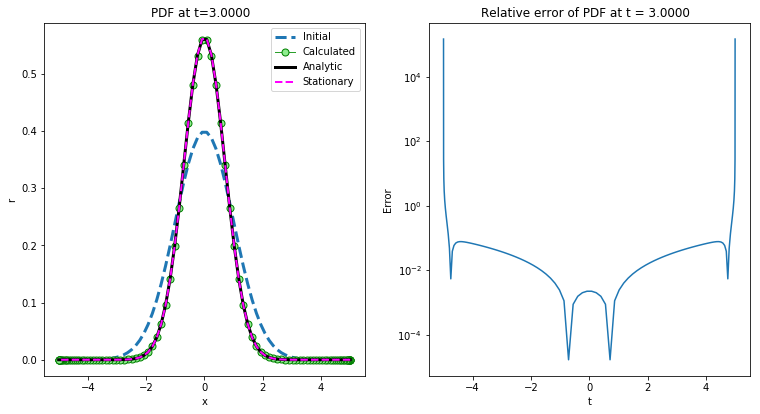

In [9]:
SL.plot_x(t=0.1)
SL.plot_x(t=0.5)
SL.plot_x(t=1.0)
SL.plot_x()

<div class="head1">
    <div class="head1__name">
        Accuracy vs number of spatial points
    </div>
    <div class="head1__note">
        Note that analytic solution is small but not zero at boundaries, hence the integral (norm) error is not small for any grid size.
    </div>
</div>

In [10]:
m = 1000
N = [10, 50, 100, 200]
Times = []
Errors = []

for n in N:
    SL = Solver(d=1, with_tt=False)
    SL.set_grid_t(m, t_min, t_max)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.set_coefs(dc)
    SL.prep()
    SL.calc()
    u_calc = SL.R[-1]
    u_real = func_rt(SL.X.reshape(1, -1), SL.T[-1])
    e = np.linalg.norm(u_real - u_calc) / np.linalg.norm(u_real)
    
    Times.append([SL._t_prep, SL._t_calc])
    Errors.append(e)

Solve: 100%|███████| 999/999 [00:35<00:00, 30.52step/s, Norm 2.25e+00]


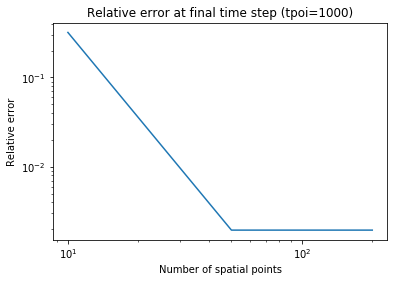



Solver info for n = 200, m = 1000 : 
---------- Solver
Format   : 1D, NP
Grid x   : poi =       200, min =   -5.0000, max =    5.0000
Grid t   : poi =      1000, min =    0.0000, max =    3.0000
Time sec : prep = 2.41e-01, calc = 2.97e+01


In [11]:
plt.plot(N, Errors)
plt.semilogx()
plt.semilogy()
plt.title('Relative error at final time step (tpoi=%d)'%m)
plt.xlabel('Number of spatial points')
plt.ylabel('Relative error')
plt.show()

print('\n\nSolver info for n = %d, m = %d : '%(N[-1], m))
SL.info()

<div class="head1">
    <div class="head1__name">
        Accuracy vs number of time points
    </div>
    <div class="head1__note">
        Note that analytic solution is small but not zero at boundaries, hence the integral (norm) error is not small for any grid size.
    </div>
</div>

In [12]:
n = 100
M = [10, 100, 1000, 5000, 10000]
Times = []
Errors = []

for m in M:
    SL = Solver(d=1, with_tt=False)
    SL.set_grid_t(m, t_min, t_max)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.set_coefs(dc)
    SL.prep()
    SL.calc()
    u_calc = SL.R[-1]
    u_real = func_rt(SL.X.reshape(1, -1), SL.T[-1])
    e = np.linalg.norm(u_real - u_calc) / np.linalg.norm(u_real)
    
    Times.append([SL._t_prep, SL._t_calc])
    Errors.append(e)

Solve: 100%|█████| 9999/9999 [02:38<00:00, 63.18step/s, Norm 1.59e+00]


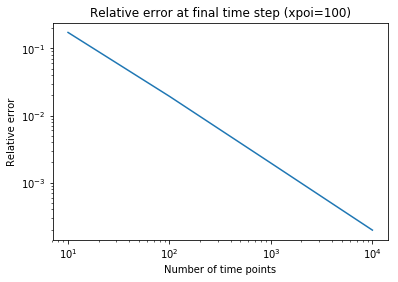



Solver info for n = 10000, m = 100 : 
---------- Solver
Format   : 1D, NP
Grid x   : poi =       100, min =   -5.0000, max =    5.0000
Grid t   : poi =     10000, min =    0.0000, max =    3.0000
Time sec : prep = 6.14e-03, calc = 1.21e+02


In [13]:
plt.plot(M, Errors)
plt.semilogx()
plt.semilogy()
#plt.ylim(4.E-6, 8.E-6)
plt.title('Relative error at final time step (xpoi=%d)'%n)
plt.xlabel('Number of time points')
plt.ylabel('Relative error')
plt.show()

print('\n\nSolver info for n = %d, m = %d : '%(M[-1], n))
SL.info()

<div class="head1">
    <div class="head1__name">
        Accuracy vs number of spatial and time points
    </div>
    <div class="head1__note">
        Note that analytic solution is small but not zero at boundaries, hence the integral (norm) error is not small for any grid size.
    </div>
</div>

Let set constant factor $p=\frac{h}{l^2}$ and calculate solution for different spatial steps $l$ (and the corresponding time steps $h = p l^2$).

In [14]:
p = 0.1
N = [10, 50, 100, 200]
M = []
Times = []
Errors = []

for n in N:
    l = (x_max - x_min) / n
    h = p * l * l
    m = int((t_max - t_min) / h) + 1
    M.append(m)
    SL = Solver(d=1, with_tt=False)
    SL.set_grid_t(m, t_min, t_max)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.set_coefs(dc)
    SL.prep()
    SL.calc()
    u_calc = SL.R[-1]
    u_real = func_rt(SL.X.reshape(1, -1), SL.T[-1])
    e = np.linalg.norm(u_real - u_calc) / np.linalg.norm(u_real)
    
    Times.append([SL._t_prep, SL._t_calc])
    Errors.append(e)

Solve: 100%|███| 11999/11999 [04:53<00:00, 40.94step/s, Norm 2.25e+00]


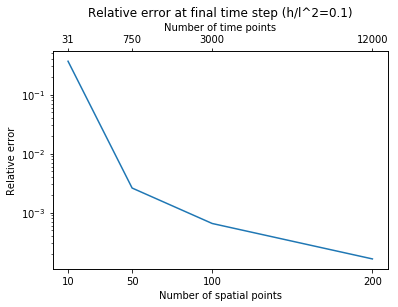

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(N, Errors)
ax1.semilogy()
ax1.set_xticks(N)
ax1.set_title('Relative error at final time step (h/l^2=%-2.1f)'%p)
ax1.set_xlabel('Number of spatial points')
ax1.set_ylabel('Relative error')
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(N)
ax2.set_xticklabels(["%d"%m for m in M])
ax2.set_xlabel('Number of time points')
plt.show()

In [16]:
p = 0.9
N = [20, 50, 100, 200]
M = []
Times = []
Errors = []

for n in N:
    l = (x_max - x_min) / n
    h = p * l * l
    m = int((t_max - t_min) / h) + 1
    M.append(m)
    SL = Solver(d=1, with_tt=False)
    SL.set_grid_t(m, t_min, t_max)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.set_coefs(dc)
    SL.prep()
    SL.calc()
    u_calc = SL.R[-1]
    u_real = func_rt(SL.X.reshape(1, -1), SL.T[-1])
    e = np.linalg.norm(u_real - u_calc) / np.linalg.norm(u_real)
    
    Times.append([SL._t_prep, SL._t_calc])
    Errors.append(e)

Solve: 100%|█████| 1333/1333 [00:34<00:00, 38.82step/s, Norm 2.25e+00]


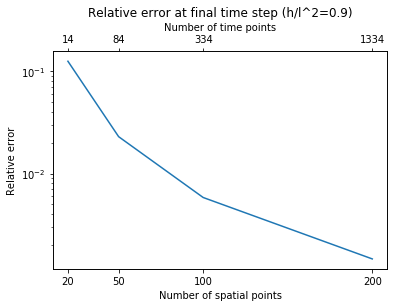

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(N, Errors)
ax1.semilogy()
ax1.set_xticks(N)
ax1.set_title('Relative error at final time step (h/l^2=%-2.1f)'%p)
ax1.set_xlabel('Number of spatial points')
ax1.set_ylabel('Relative error')
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(N)
ax2.set_xticklabels(["%d"%m for m in M])
ax2.set_xlabel('Number of time points')
plt.show()

<div class="head1">
    <div class="head1__name">
        Proof of analytic formula for 1D PDF
    </div>
</div>

Let calculate PDF $\rho(x, t)$ at time $t$ in some spatial point $x$ using transition PDF $\rho(x, t, x_0)$
$$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{2 \pi \Sigma(t)}}
        \exp{\left[
            -\frac{(x - e^{-A t} x_0)^2}{2 \Sigma(t)}
        \right]},
$$
and fixed initial condition
$$
    \rho_0(x) =
        \frac{1}{\sqrt{2 \pi s}}
        \exp{\left[
            -\frac{x^2}{2 s}
        \right]},
$$
from equation
$$
    \rho(x, t) = \int_{-\infty}^{\infty}
        \rho(x, t, x_0) \rho_0(x_0) \, d x_0.
$$

We have
$$
    \rho(x, t) = \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}\int_{-\infty}^{\infty}
        \exp{\left[
            -\frac{(x - e^{-A t} x_0)^2}{2 \Sigma(t)}  -\frac{x_0^2}{2 s}
        \right]}
        \, d x_0,
$$

$$
    \rho(x, t) = \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}\int_{-\infty}^{\infty}
        \exp{\left[
            -\frac{s (x - e^{-A t} x_0)^2 + \Sigma(t) x_0^2}{2 \Sigma(t) s}
        \right]}
        \, d x_0,
$$

$$
    \rho(x, t) =
        \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
        \exp{\left[
            -\frac{x^2}{2 \Sigma(t)}
        \right]}
        \int_{-\infty}^{\infty}
            \exp{\left[
                \frac{- s e^{-2 A t} x_0^2 + 2 s x e^{-A t} x_0 - \Sigma(t) x_0^2}{2 \Sigma(t) s}
            \right]}
            \, d x_0,
$$

$$
    \rho(x, t) =
        \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
        \exp{\left[
            -\frac{x^2}{2 \Sigma(t)}
        \right]}
        \int_{-\infty}^{\infty}
            \exp{\left[
                - \frac{s e^{-2 A t} + \Sigma(t)}{2 \Sigma(t) s} x_0^2
                + \frac{x e^{-A t}}{\Sigma(t)} x_0
            \right]}
            \, d x_0,
$$

Since
$$
    \int_{-\infty}^{\infty} e^{-a x^2 + b x} \, d x =
        \sqrt{\frac{\pi}{a}} e^{\frac{b^2}{4a}},
    \quad
    a > 0,
$$
we come to
$$
    \rho(x, t) =
        \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
        \exp{\left[
            -\frac{x^2}{2 \Sigma(t)}
        \right]}
        \sqrt{\frac{2 \pi \Sigma(t) s}{s e^{-2 A t} + \Sigma(t)}}
        \exp{\left[
            \frac{2 \Sigma(t) s x^2 e^{-2 A t}}{4 \Sigma^2(t) (s e^{-2 A t} + \Sigma(t))}
        \right]},
$$

$$
    \rho(x, t) =
        \sqrt{
            \frac
                {
                    1
                }
                {
                    2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        }
        \exp{\left[
            \frac
                {
                    s x^2 e^{-2 A t}
                }
                {
                    2 \Sigma(t) \left( s e^{-2 A t} + \Sigma(t) \right)
                }
            -
            \frac
                {
                    x^2
                }
                {
                    2 \Sigma(t)
                }
        \right]},
$$

$$
    \rho(x, t) =
        \sqrt{
            \frac
                {
                    1
                }
                {
                    2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        }
        \exp{\left[
            \frac
                {
                    s e^{-2 A t} - s e^{-2 A t} - \Sigma(t)
                }
                {
                    2 \Sigma(t) \left( s e^{-2 A t} + \Sigma(t) \right)
                }
            x^2
        \right]},
$$

$$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)}
            }
        \exp{\left[
            - \frac
                {
                    x^2
                }
                {
                    2 \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        \right]}.
$$

<div class="end"></div>